In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [8]:
BUFFER_SIZE = 84434
BATCH_SIZE = 128


def load_image(img_path):
    img = tf.io.read_file(img_path) 
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [64, 64])
    img /= 255.0
    return img


train_dataset = tf.data.Dataset.list_files('D:/Data/Face/celeba/Male/positive/*.jpg') \
    .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
    .batch(BATCH_SIZE)

In [4]:
def make_generator_model():
    model = tf.keras.Sequential()

    model.add(tf.keras.Input(shape=(100, )))

    model.add(layers.Dense(8 * 8 * 256, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5),
                               strides=(1, 1),
                               padding='same',
                               use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    assert model.output_shape == (None, 8, 8, 128)

    model.add(layers.Conv2DTranspose(64, (5, 5),
                               strides=(2, 2),
                               padding='same',
                               use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    assert model.output_shape == (None, 16, 16, 64)

    model.add(layers.Conv2DTranspose(32, (5, 5),
                               strides=(2, 2),
                               padding='same',
                               use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    assert model.output_shape == (None, 32, 32, 32)

    model.add(layers.Conv2DTranspose(3, (5, 5),
                               strides=(2, 2),
                               padding='same',
                               use_bias=False,
                               activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3)


    return model


def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(64, 64, 3)))

    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


In [11]:
print(tf.__version__)

2.2.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
tf.Tensor(
[[[[ 2.9815439e-04 -8.1353919e-06  3.2862634e-04]
   [ 6.9582765e-04  7.5173483e-04  7.8358955e-04]
   [-3.1983905e-04 -8.7582972e-05 -3.4740020e-05]
   ...
   [ 4.5229523e-03 -5.6316494e-06  3.7060835e-04]
   [-1.6883453e-03 -8.8992651e-04  4.8273779e-04]
   [-8.7276829e-04 -2.9285543e-04  1.9185084e-03]]

  [[ 2.9139378e-04 -9.7146514e-04  2.0371409e-04]
   [-1.3415095e-03 -9.6707279e-04  7.5790304e-04]
   [-1.0558292e-03  2.5518530e-05 -4.3926309e-05]
   ...
   [ 6.5611498e-03  9.3334465e-04  3.4783443e-03]
   [ 1.7681916e-04  5.9943809e-04 -9.5837744e-04]
   [ 9.0338656e-04  2.7212184e-03 -1.8017684e-03]]

  [[-5.7707669e-04  1.2625247e-04 -2.5374873e-05]
   [ 1.2343503e-03  1.6034762e-03  7.3215319e-04]
   [-1.1444761e-03  2.8378432e-05 -1.4919980e-04]
   ...
   [-1.8722422e-03 -1.8011356e-03 -2.5657043e-03]
   [-1.2675682e-03  8.1268552e-04  5.7020190e-04]
   [

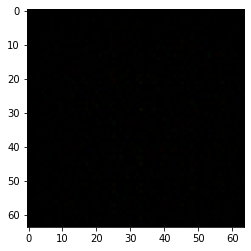

In [16]:
noise = tf.random.normal([1, 100])
generator = make_generator_model()
predict = generator(noise, training=False)
print(predict)
plt.imshow(predict[0])
plt.show()


In [15]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

generator_loss_measure = tf.keras.metrics.Mean(name='train_loss')

2.6848316192626953
1.8379747867584229
1.46199369430542
0.18597078323364258
0.0689995288848877
0.03096914291381836
0.055999755859375
0.060968637466430664
0.24996662139892578
0.21799182891845703
0.025969505310058594
0.08799982070922852
0.24696850776672363
0.30300140380859375
0.3829967975616455
0.07896828651428223
0.23099851608276367
0.0209958553314209
0.197998046875
0.0650026798248291
0.025000333786010742
0.05999612808227539
0.16800260543823242
0.19402670860290527
0.1620314121246338
0.054999351501464844
0.15601587295532227
0.05899691581726074
0.1780080795288086
0.14399957656860352
0.10296869277954102
0.13097047805786133
0.026000261306762695
0.13702797889709473
0.1360018253326416
0.14200067520141602
0.08500099182128906
0.014002323150634766
0.020999908447265625
0.020001649856567383
0.09702825546264648
0.05800056457519531
0.031998395919799805
0.07896828651428223
0.027998924255371094
0.04400038719177246
0.052971839904785156
0.06597137451171875
0.09300112724304199
0.2020127773284912
0.1059987

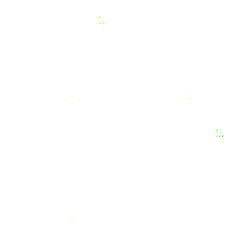

Time for epoch 1 is 293.5308539867401 sec
0.17396950721740723
0.06600069999694824
0.10799932479858398
0.0579991340637207
0.07199907302856445
0.056970834732055664


KeyboardInterrupt: 

In [11]:
# 注意 `tf.function` 的使用
# 该注解使函数被“编译”
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # generator_loss_measure(gen_loss)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


def generate_and_save_images(model, epoch, test_input):
    # 注意 training` 设定为 False
    # 因此，所有层都在推理模式下运行（batchnorm）。
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i,:,:,:])
        plt.axis('off')

    plt.savefig('./output/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            start1 = time.time()
            train_step(image_batch)
            print(time.time() - start1)

        # 继续进行时为 GIF 生成图像
        # display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # 每 15 个 epoch 保存一次模型
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print('Time for epoch {} is {} sec'.format(epoch + 1,
                                                   time.time() - start))

    # 最后一个 epoch 结束后生成图片
    # display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)


generator = make_generator_model()
discriminator = make_discriminator_model()

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator)

EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# 我们将重复使用该种子（因此在动画 GIF 中更容易可视化进度）
seed = tf.random.normal([num_examples_to_generate, noise_dim])

train(train_dataset, EPOCHS)